In [0]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import math
import csv
from google.colab import files
from collections import deque

In [4]:
uploaded = files.upload()

Saving mnist.csv to mnist.csv


In [5]:
file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)   #10000개
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
train_image  = np.empty((size_row * size_col, 1000), dtype=float)
train_label  = np.empty(1000, dtype=int)
test_image  = np.empty((size_row * size_col, 9000), dtype=float)
test_label  = np.empty(9000, dtype=int)

for line in data:
    if count < 1000 :
      line_data   = line.split(',')
      label       = line_data[0]
      im_vector   = np.asfarray(line_data[1:])
      im_vector   = normalize(im_vector)

      train_label[count]       = label       # size : 10000
      train_image[:, count]    = im_vector   # size : 784 * 10000

    else: 
      line_data   = line.split(',')
      label       = line_data[0]
      im_vector   = np.asfarray(line_data[1:])
      im_vector   = normalize(im_vector)

      test_label[count-1000]       = label       # size : 10000
      test_image[:, count-1000]    = im_vector   # size : 784 * 10000

    count += 1

train_costs = deque()
test_costs = deque()
theta_0s = deque()
theta_1s = deque()
theta_2s = deque()
bias_0s = deque()
bias_1s = deque()
bias_2s = deque()
iters = deque()
train_accuracys = deque()
test_accuracys = deque()
incorrect_predicts = deque()

#correct_labels = []
correct_labels = deque()
#incorrect_labels = []
incorrect_labels = deque()

print(num_image)  #10000
print(len(train_image))  #784
print(len(train_image[0]))  #1000
print(len(train_label))  #1000
print(len(test_image))  #784
print(len(test_image[0]))  #9000
print(len(test_label))  #9000
print(train_image.shape)

train_length = len(train_label)
train_l = np.zeros((10,1000))
for i in range(0,train_length):
  index = train_label[i]
  a = np.zeros(10)
  a[index] = 1
  train_l[:,i] = a
print(train_l)
print(train_l.shape)

test_length = len(test_label)
test_l = np.zeros((10,9000))
for i in range(0,test_length):
  index = test_label[i]
  a = np.zeros(10)
  a[index] = 1
  test_l[:,i] = a
print(test_l)
print(test_l.shape)
print(test_l[:,8999])
#list_label 0~5999까지 training data, 6000~9999까지 test data
#list_image [:,5999]까지 training data, [:,9999]까지 test data

10000
784
1000
1000
784
9000
9000
(784, 1000)
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(10, 1000)
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(10, 9000)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [0]:
def forward(theta, value):
  #print(theta.shape, value.shape)
  #print("Theta", theta.shape)
  #print("value", value.shape)
  result = np.matmul(theta, value)
  return result

In [0]:
def sigmoid(value):
  """
  length = len(value)
  for i in range(0, length):
    value[i] = 1 / (1 + np.exp(-value[i]))
  """
  value = value.astype(float)
  value = np.multiply(value,-1)
  value = np.exp(value)
  value = np.add(1,value)
  value = np.divide(1, value)
  return value

In [0]:
def addBias(value, bias):
  """
  length = len(bias)
  for i in range(0, length):
    value[i] += bias[i]
  """
  value = np.add(value, bias)
  return value

In [0]:
def neuralNet(x, u, bias0):    #data, theta0, theta1, theta2, bias0, bias1, bias2
  y_hat = forward(u, x)
  y_hat = addBias(y_hat, bias0)
  y = sigmoid(y_hat)
  """
  z_hat = forward(v, y)
  z_hat = addBias(z_hat, bias1)
  z = sigmoid(z_hat)
  h_hat = forward(w, z)
  h_hat = addBias(h_hat, bias2)
  h = sigmoid(h_hat)
  """
  return y

In [0]:
def objectiveFunction(image, l, lamda, y, theta0, b0):     #list_image[:, count], list_label -> traing과 test 구분해야겠다.!!
  length = len(image[0])                    #두는 이유는 trainig 6000, test 4000개  갯수가 달라서
  cost1 = np.log(y)      # **** y size : 10x 1000 바꾸기(main, neural net)
  cost1 = np.multiply(cost1, l)
  cost1 = np.multiply(cost1, -1)
  cost2 = np.subtract(1, y)
  cost2 = np.log(cost2)
  temp = np.subtract(1, l)
  cost2 = np.multiply(cost2, temp)
  cost = np.subtract(cost1, cost2)
  cost = np.divide(cost,length)
  cost = np.sum(cost)
  cost_r = np.multiply(theta0, theta0)
  cost_r = np.sum(cost_r)
  cost_r = cost_r * lamda / (2*7840)          #추후에 theta 추가나 값 size 변경시 이곳 변경!!!!!
  cost += cost_r
  
  return cost

In [0]:
def gradientDescent(image, l, lamda, learning_rate, y, theta0, b0):
  lr = learning_rate
  length = len(image[0])

  x_transpose = np.reshape(image, (1000,784))
  #######theta0
  partial_0 = np.subtract(y, l)
  partial_theta0 = np.matmul(partial_0, x_transpose)
  regular_theta0 = np.sum(theta0)
  regular_theta0 = np.multiply(regular_theta0, lamda)
  regular_theta0 = np.divide(regular_theta0, 7840) 
  partial_theta0 = np.sum(partial_theta0, regular_theta0)
  partial_theta0 = np.multiply(partial_theta0, lr)
  theta0 = np.subtract(theta0, partial_theta0)
  
  #######bias0
  partial_bias0 = np.ones((1000,1))
  partial_bias0 = np.matmul(partial_0, partial_bias0)
  partial_bias0 = np.divide(partial_bias0, 1000)      ## 확실치 않음 없애야할수도 있다!
  partial_bias0 = np.multiply(partial_bias0, lr)
  b0 = np.subtract(b0, partial_bias0)

  return theta0, b0

In [0]:
def checkAccuracy(image, label, y, theta0, b0):
  length = len(label)
  count = 0
  for i in range(0, length):
    if label[i] == np.argmax(y[:,i]):
      count += 1
  accuracy = count / length
  return accuracy

In [0]:
def checkCorrect(image, label, y, theta0, b0):
  length = len(label)
  count = 0
  labels = []
  for i in range(0, length):
    if count == 10:
      break
    else:
      if label[i] == np.argmax(y[:,i]):
        labels.append(i)  #index를 labels 리스트에 추가
        count += 1
  return labels

In [0]:
def checkIncorrect(image, label, y, theta0, b0):
  length = len(label)
  count = 0
  labels = []
  predicts = []
  for i in range(0, length):
    if count == 10:
      break
    else:
      if label[i] != np.argmax(y[:,i]):
        labels.append(i)  #index를 labels 리스트에 추가
        count += 1
        predicts.append(np.argmax(y[:,i]))
  return labels, predicts

In [17]:
def main():
  mu = 0
  sigma = 0.1
  lamda = 0

  theta_0 = np.random.normal(mu, sigma, size=(10,784))   #size = 196x784
  #theta_1 = np.random.normal(mu, sigma, size=(49,196))    #size = 49x196
  #theta_2 = np.random.normal(mu, sigma, size=(10,49))     #size = 10x49
  
  b_0 = np.random.normal(mu, sigma, size=(10,1))                  #size = 196x1
  #b_1 = np.random.normal(mu, sigma, 49)                   #size = 49x1
  #b_2 = np.random.normal(mu, sigma, 10)                   #size = 10x1

  lr = 1                                                #learning rate

  #training step
  for iter in range(0, 10):
    iters.append(iter)
    y = neuralNet(train_image, theta_0, b_0)
    print("y",y)
    train_cost = objectiveFunction(train_image, train_l, lamda, y, theta_0, b_0)  #print(cost)
    print("traincost",train_cost)
    print("##########################################111111111111111111111111111111",iter)
    train_costs.append(train_cost)
    theta_0, b_0 = gradientDescent(train_image, train_l, lamda, lr, y, theta_0, b_0)
    print("b0", b_0)
    #############train accuracy 하자!############
    train_accuracy = checkAccuracy(train_image, train_label, y, theta_0, b_0)
    print("accuracy",train_accuracy)
    train_accuracys.append(train_accuracy)
    print("##########################################12222222222")
    correct_label = checkCorrect(test_image, test_label, y, theta_0, b_0)
    correct_labels.append(correct_label)

    #########test
    y = neuralNet(test_image, theta_0, b_0)
    test_cost = objectiveFunction(test_image, test_l, lamda, y, theta_0, b_0)
    print("##########################################33333333333")
    test_costs.append(test_cost)
    #############test accuracy
    test_accuracy = checkAccuracy(test_image, test_label, y, theta_0, b_0)
    test_accuracys.append(test_accuracy)
    incorrect_label, predict = checkIncorrect(test_image, test_label, y, theta_0, b_0)
    incorrect_labels.append(incorrect_label)
    incorrect_predicts.append(predict)
    #train_y, train_z, train_h = neuralNet(train_image, theta_0, theta_1, theta_2, b_0, b_1, b_2) #image 문제
    print("##########################################4444444444444444444")
    theta_0s.append(theta_0)
    bias_0s.append(b_0)
    
  ######correct label 가져오자!
  #correct_labels = checkCorrect(test_image, test_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)  #data의 index만 헐당!

  #incorrect_labels = checkIncorrect(test_image, test_label, theta_0, theta_1, theta_2, b_0, b_1, b_2)


if __name__ == "__main__":
  main()

y [[0.76588256 0.26519834 0.54108222 ... 0.22144583 0.56440004 0.56460274]
 [0.28315036 0.25930549 0.50214779 ... 0.48893544 0.21273051 0.51953402]
 [0.71413611 0.44656114 0.55309757 ... 0.43037112 0.92252874 0.82868036]
 ...
 [0.52223599 0.81018525 0.56649099 ... 0.65008224 0.71311476 0.43460721]
 [0.50351411 0.51885877 0.68139281 ... 0.84835235 0.76122377 0.58842863]
 [0.35955878 0.50884025 0.53103235 ... 0.18216472 0.49484079 0.65792804]]
traincost 8.182260675980535
##########################################111111111111111111111111111111 0


TypeError: ignored

### **1. Plot the loss curve**

deque([7.021563122164063, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])


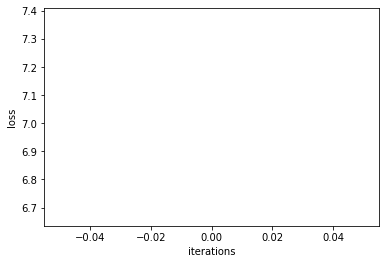

In [0]:
fig = plt.figure()
print(train_costs)
graph1 = plt.plot(iters, train_costs, 'b')
graph2 = plt.plot(iters, test_costs, 'r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

In [1]:
fig = plt.figure()
print("theta,bias")
graph1 = plt.plot(iters, theta_0s, 'b')
graph2 = plt.plot(iters, bias_0s, 'r')
plt.xlabel('iterations')
plt.ylabel('unknown')
plt.show()

NameError: ignored

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


### **2. Plot the accuracy curve**

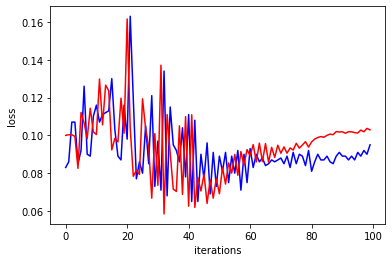

In [0]:
fig = plt.figure()
graph3 = plt.plot(iters, train_accuracys, 'b')
graph4 = plt.plot(iters, test_accuracys, 'r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

### **3. Plot the accuracy value**

In [0]:
final_train_accuracy = train_accuracys[-1]
final_test_accuracy = test_accuracys[-1]
print("final_train_accuracys :", final_train_accuracy,"%")
print("final_test_accuracys :", final_test_accuracy,"%")

final_train_accuracys : 0.095 %
final_test_accuracys : 0.10255555555555555 %


### **4. Plot the classification example**

deque([[8, 14, 25, 30, 44, 48, 58, 88, 90, 108], [1, 9, 34, 47, 61, 84, 94, 121, 148, 154], [1, 9, 34, 47, 61, 84, 94, 121, 148, 154], [6, 12, 21, 39, 55, 91, 96, 100, 104, 110], [2, 16, 31, 36, 49, 50, 53, 56, 65, 76], [10, 15, 42, 57, 59, 66, 67, 69, 77, 78], [4, 8, 11, 19, 25, 27, 30, 37, 38, 40], [1, 9, 34, 47, 61, 84, 94, 121, 148, 154], [3, 22, 32, 41, 46, 70, 73, 82, 87, 89], [14, 17, 35, 44, 79, 85, 99, 106, 108, 123], [1, 9, 34, 47, 61, 84, 94, 121, 148, 154], [1, 9, 34, 47, 61, 84, 94, 121, 148, 175], [1, 6, 12, 21, 39, 45, 55, 81, 90, 91], [65, 66, 67, 69, 95, 114, 127, 128, 134, 138], [4, 8, 11, 19, 25, 27, 30, 37, 38, 54], [2, 16, 31, 35, 36, 49, 50, 56, 65, 76], [1, 9, 34, 47, 61, 84, 94, 121, 148, 154], [1, 9, 34, 47, 61, 84, 94, 121, 148, 154], [1, 9, 34, 47, 61, 84, 94, 121, 148, 154], [1, 9, 34, 47, 61, 84, 94, 121, 148, 154], [1, 9, 10, 15, 23, 24, 43, 57, 59, 77], [10, 15, 42, 57, 59, 66, 69, 77, 78, 111], [4, 8, 11, 19, 25, 27, 30, 38, 54, 55], [7, 26, 34, 46, 52, 

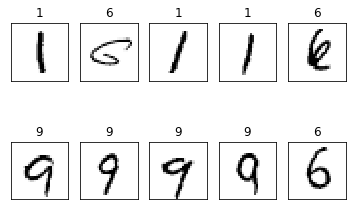

deque([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [7, 7, 7, 0, 7, 7, 7, 7, 7, 7], [2, 2, 2, 2, 2, 2, 2, 2, 7, 2], [3, 4, 4, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [6, 6, 6, 6, 6, 6, 6, 6, 6, 6], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [7, 9, 0, 0, 7, 7, 3, 7, 7, 7], [3, 4, 4, 3, 3, 2, 2, 3, 3, 3], [6, 1, 1, 1, 1, 1, 1, 8, 1, 1], [2, 2, 2, 2, 2, 2, 2, 2, 6, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 4, 4, 0, 3, 4, 4, 4, 0], [4, 4, 4, 3, 3, 3, 3, 4, 3, 3], [7, 1, 1, 1, 2, 1, 1, 9, 1, 1], [0, 8, 8, 0, 0, 0, 0, 0, 8, 0], [5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [2, 2, 0, 2, 2, 2, 2, 2, 2, 0], [6, 9, 9, 3, 3, 2, 2, 2, 3, 3], [6, 6, 6, 4, 0, 6, 6, 0, 0, 7], [8, 8, 8, 4, 4, 2, 2, 4, 8, 4], [7, 1, 0, 2, 3, 0, 0, 7, 0, 0], [2, 9, 9, 4, 3, 2, 2, 4, 9, 3], [8, 8, 8, 0, 0, 8, 0, 0, 0, 8], [

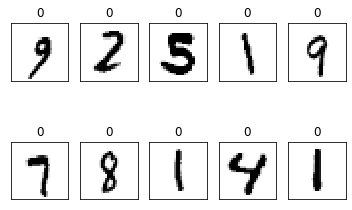

In [0]:
f2 = plt.figure(2)
im_correct  = np.zeros((size_row * size_col, 10), dtype=float)
print(correct_labels)
print(correct_labels[0][1])
print(incorrect_labels)
label_correct_index = []
label_incorrect_index = []

for i in range(10):
    correct_index = correct_labels[0][i]
    im_correct[:, i] += test_image[:, correct_index]
    label_correct_index.append(test_label[correct_index])

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(label_correct_index[i])
    plt.imshow(im_correct[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()
###################################################
print(incorrect_predicts)

f2 = plt.figure(2)
im_incorrect  = np.zeros((size_row * size_col, 10), dtype=float)

for i in range(10):
    incorrect_index = incorrect_labels[0][i]
    im_incorrect[:, i] += test_image[:, incorrect_index]
    label_incorrect_index.append(test_label[incorrect_index])

for i in range(10):
    plt.subplot(2, 5, i+1)
    value = incorrect_predicts[0][i]
    plt.title(value)
    plt.imshow(im_incorrect[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()